<a href="https://colab.research.google.com/github/mzaoualim/cryptocurrency_portfolio_optimization_app/blob/main/crypto_portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --quiet
!pip install yahooquery --quiet
!pip install requests_html --quiet
!pip install ydata_profiling --quiet
!pip install PyPortfolioOpt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.9/344.9 KB 7.7 MB/s eta 0:

In [2]:
# Modules imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
from yahooquery import Screener
import requests
from requests_html import HTMLSession
from datetime import datetime
from ydata_profiling import ProfileReport
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# The goal
Inspired by the G-Reseach competition in [Kaggle](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview) and [this portfolio optimizer tool](https://www.portfoliovisualizer.com/optimize-portfolio)

our goal is to Create a Streamlit App to generate, for a given:
  - porfolio of cryptocurrencies.
  - Budget.
  - Investements withdrawal horizon.

The optimized ratio of chosen currencies with the predicted profits.

# The Data
We'll start with a selection of 3 most popular crypto currencies on the market by market capitalization.

## Getting Data

For scraping historical trading data of the crypto currencies, we rely on Yahoo! finance API.
Fortunatly there is a python [project](https://pypi.org/project/yfinance/) who offers an easy pythonic way to get data.

In [3]:
# Scraping list of 10 most popular crypto tickets (cc)

session = HTMLSession()
num_currencies=10
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
cc = df.Symbol.tolist()
cc

['BTC-USD',
 'ETH-USD',
 'USDT-USD',
 'BNB-USD',
 'USDC-USD',
 'XRP-USD',
 'ADA-USD',
 'HEX-USD',
 'DOGE-USD',
 'MATIC-USD']

In [4]:
# For the given cryptocurrencies, we grab max available histrical closing price data:

tickers = yf.Tickers(cc)
end_date = datetime.now().strftime('%Y-%m-%d')
data = tickers.history(period='max',end=end_date,interval='1d')['Close']
data

[*********************100%***********************]  10 of 10 completed


ADA-USD     BNB-USD       BTC-USD  DOGE-USD      ETH-USD  \
Date                                                                    
2014-09-17       NaN         NaN    457.334015       NaN          NaN   
2014-09-18       NaN         NaN    424.440002       NaN          NaN   
2014-09-19       NaN         NaN    394.795990       NaN          NaN   
2014-09-20       NaN         NaN    408.903992       NaN          NaN   
2014-09-21       NaN         NaN    398.821014       NaN          NaN   
...              ...         ...           ...       ...          ...   
2023-03-03  0.342737  290.282837  22362.679688  0.076777  1569.167603   
2023-03-04  0.336499  289.503876  22353.349609  0.074556  1566.923950   
2023-03-05  0.337102  288.699707  22435.513672  0.074795  1564.468750   
2023-03-06  0.330821  288.054962  22429.757812  0.074805  1567.398682   
2023-03-07  0.330483  289.343689  22219.769531  0.074048  1561.933105   

             HEX-USD  MATIC-USD  USDC-USD  USDT-USD   XRP-USD  
Date                                                           
2014-09-17       NaN        NaN       NaN       NaN       NaN  
2014-09-18       NaN        NaN       NaN       NaN       NaN  
2014-09-19       NaN        NaN       NaN       NaN       NaN  
2014-09-20       NaN        NaN       NaN       NaN       NaN  
2014-09-21       NaN        NaN       NaN       NaN       NaN  
...              ...        ...       ...       ...       ...  
2023-03-03  0.069856   1.167757  1.000000  1.000100  0.377671  
2023-03-04  0.065747   1.126445  1.000048  1.000114  0.373813  
2023-03-05  0.068898   1.137450  1.000010  1.000107  0.367194  
2023-03-06  0.070193   1.131752  0.999953  1.000011  0.370471  
2023-03-07  0.065402   1.149590  1.000081  1.000013  0.380548  

[3094 rows x 10 columns]

## Preprocessing Data

In [5]:
# missing data
data.isna().sum()

ADA-USD      1149
BNB-USD      1149
BTC-USD         0
DOGE-USD     1149
ETH-USD      1149
HEX-USD      1917
MATIC-USD    1684
USDC-USD     1482
USDT-USD     1149
XRP-USD      1149
dtype: int64

In [6]:
# data length before removing missing data
len(data)

3094

In [7]:
# after removing row with missing obs
data = data.dropna(axis=0)
len(data)


1177

These missing data are caused by differences in starting dates of trading of each currency.

In [8]:
data.isna().sum()

ADA-USD      0
BNB-USD      0
BTC-USD      0
DOGE-USD     0
ETH-USD      0
HEX-USD      0
MATIC-USD    0
USDC-USD     0
USDT-USD     0
XRP-USD      0
dtype: int64

In [9]:
data.dtypes

ADA-USD      float64
BNB-USD      float64
BTC-USD      float64
DOGE-USD     float64
ETH-USD      float64
HEX-USD      float64
MATIC-USD    float64
USDC-USD     float64
USDT-USD     float64
XRP-USD      float64
dtype: object

In [10]:
# Save data to csv for future manipulations
data.to_csv('data')

# EDA

In [11]:
data.describe()

ADA-USD      BNB-USD       BTC-USD     DOGE-USD      ETH-USD  \
count  1177.000000  1177.000000   1177.000000  1177.000000  1177.000000   
mean      0.711705   241.502683  28227.042122     0.099399  1661.938132   
std       0.690157   185.292706  16777.990023     0.108795  1240.604737   
min       0.023961     9.386050   4970.788086     0.001537   110.605873   
25%       0.122477    27.705311  11754.045898     0.003197   391.384491   
50%       0.446665   277.293915  23031.089844     0.069125  1553.037354   
75%       1.191124   374.658813  42197.515625     0.146453  2603.466553   
max       2.968239   675.684082  67566.828125     0.684777  4812.087402   

           HEX-USD    MATIC-USD     USDC-USD     USDT-USD      XRP-USD  
count  1177.000000  1177.000000  1177.000000  1177.000000  1177.000000  
mean      0.072575     0.735429     1.000780     1.000614     0.532661  
std       0.099320     0.684382     0.004126     0.002649     0.335232  
min       0.000015     0.008096     0.970124     0.974248     0.139635  
25%       0.004427     0.020925     0.999914     1.000017     0.268342  
50%       0.031409     0.772779     1.000076     1.000257     0.398085  
75%       0.117530     1.251412     1.000372     1.000804     0.753154  
max       0.486741     2.876757     1.044029     1.053585     1.839236

## Pandas Profiling

In [12]:
# Trying  ydata-profiling 
profile = ProfileReport(data, tsmode=True)

In [13]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation Analysis

<AxesSubplot:>

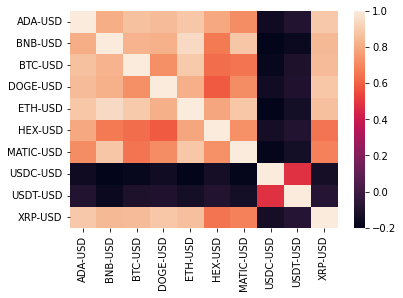

In [15]:
corr = data.corr()

sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)

## Volatility Analysis

In [ ]:
# Volatility analysis
# https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/
# https://ionides.github.io/531w22/final_project/project22/blinded.html

In [23]:
(np.log(data/data.shift()).std()*365**.5)

ADA-USD      1.096350
BNB-USD      1.042567
BTC-USD      0.726735
DOGE-USD     1.633508
ETH-USD      0.962006
HEX-USD      2.716870
MATIC-USD    1.461581
USDC-USD     0.061593
USDT-USD     0.061295
XRP-USD      1.159028
dtype: float64

Text(0, 0.5, 'Freq of log return')

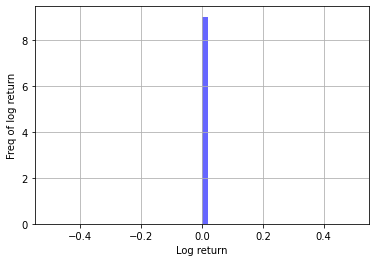

# Modeling

## Base-line Model: Mean-variance optimization

### Optimistic Portfolio

Pursuing the highest gains possible regardless of risks levels.

In [ ]:
mu = mean_historical_return(data)
S = CovarianceShrinkage(data).ledoit_wolf()

In [ ]:
mu

ADA-USD      0.652531
BNB-USD      0.963691
BTC-USD      0.298293
DOGE-USD     1.170213
ETH-USD      0.727215
HEX-USD      2.634703
MATIC-USD    1.648231
USDC-USD     0.000263
USDT-USD     0.001437
XRP-USD      0.162351
dtype: float64

In [ ]:
S

ADA-USD   BNB-USD   BTC-USD  DOGE-USD   ETH-USD   HEX-USD  \
ADA-USD    1.764172  0.164399  0.121487  0.186106  0.173141  0.089257   
BNB-USD    0.164399  1.744332  0.117529  0.130613  0.159362  0.072923   
BTC-USD    0.121487  0.117529  1.602206  0.135719  0.127502  0.069286   
DOGE-USD   0.186106  0.130613  0.135719  2.927139  0.162149  0.089207   
ETH-USD    0.173141  0.159362  0.127502  0.162149  1.690126  0.100925   
HEX-USD    0.089257  0.072923  0.069286  0.089207  0.100925  5.814692   
MATIC-USD  0.237056  0.230399  0.147547  0.166126  0.214503  0.087273   
USDC-USD  -0.001052 -0.001093 -0.000869 -0.001009 -0.001283  0.000796   
USDT-USD  -0.001972 -0.001908 -0.001568 -0.001575 -0.002162  0.005699   
XRP-USD    0.171563  0.155507  0.112745  0.159033  0.157687  0.077840   

           MATIC-USD  USDC-USD  USDT-USD   XRP-USD  
ADA-USD     0.237056 -0.001052 -0.001972  0.171563  
BNB-USD     0.230399 -0.001093 -0.001908  0.155507  
BTC-USD     0.147547 -0.000869 -0.001568  0.112745  
DOGE-USD    0.166126 -0.001009 -0.001575  0.159033  
ETH-USD     0.214503 -0.001283 -0.002162  0.157687  
HEX-USD     0.087273  0.000796  0.005699  0.077840  
MATIC-USD   2.009665 -0.001328 -0.002256  0.210443  
USDC-USD   -0.001328  1.486166  0.000684 -0.001069  
USDT-USD   -0.002256  0.000684  1.486155 -0.001704  
XRP-USD     0.210443 -0.001069 -0.001704  1.804838

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('ADA-USD', 0.07183), ('BNB-USD', 0.17251), ('BTC-USD', 0.00453), ('DOGE-USD', 0.13891), ('ETH-USD', 0.1039), ('HEX-USD', 0.19502), ('MATIC-USD', 0.3133), ('USDC-USD', 0.0), ('USDT-USD', 0.0), ('XRP-USD', 0.0)])


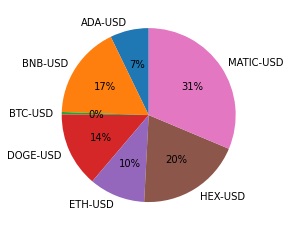

In [ ]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 148.3%
Annual volatility: 82.1%
Sharpe Ratio: 1.78


(1.482794372609942, 0.82055002597505, 1.7826998065982882)

Crypto trading allow for fraction buy/sell of currencies. so we dont need discrete allocation of coins.

### Risk Averse portfolio

In [ ]:
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('ADA-USD', 0.09129), ('BNB-USD', 0.09714), ('BTC-USD', 0.11759), ('DOGE-USD', 0.05574), ('ETH-USD', 0.09815), ('HEX-USD', 0.03458), ('MATIC-USD', 0.06968), ('USDC-USD', 0.17112), ('USDT-USD', 0.17133), ('XRP-USD', 0.09338)])


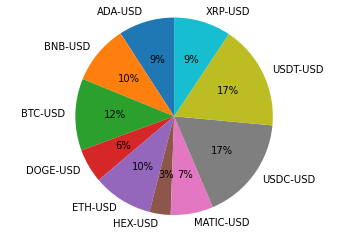

In [ ]:
labels = [i for i in cleaned_weights.keys() if cleaned_weights[i] != 0]
sizes = [i for i in cleaned_weights.values() if i != 0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
ef.portfolio_performance(verbose=True)

Expected annual return: 54.6%
Annual volatility: 50.4%
Sharpe Ratio: 1.04


(0.5462675571141528, 0.5037634324759528, 1.044672009096798)

## Machine Learning solution

In [ ]:
#  Tree Based Model

## Deep Learning Solution

In [ ]:
# https://www.quantconnect.com/terminal/processCache/?request=embedded_backtest_4ebbe01bfea8c5ae6f98fcda38a50b1c.html

# Streamlit App

In [ ]:
# Design
#  3 pages app
## page 1: choose (portfolio, budget, horizon)
## page 2: basic EDA (history, volatility...)
## page 3: portfolio ratio/profits/probabilities

# Conclusion

Beyond the App
- Portfolio builder App

# References
[Getting Crypto Symbols](https://stackoverflow.com/a/74656748)

[Portfolio Optimization Using Python](https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb)

[Portfolio Builder](https://github.com/yeungadrian/PortfolioBuilder)

[Portfolio Selection with Graph Algorithms and Deep Learning](https://www.linkedin.com/pulse/portfolio-selection-graph-algorithms-deep-learning-maya-benowitz)

[G-Research Crypto Forecasting](https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview)

[G-Research Crypto Forecasting](https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition/notebook#Preprocessing)

[yfinance guide](https://www.qmr.ai/yfinance-library-the-definitive-guide/#Fetch_Historical_Prices_using_yfinance
)

[Portfolio Optimization with PyPortfolioOpt](https://github.com/paulsg3/PortfolioOptimization/blob/main/Portfolio_Optimization.ipynb)

[PyPortfolioOpt Documentation](https://pyportfolioopt.readthedocs.io/en/latest/)

[Portfolio Optimization using Reinforcement Learning](https://github.com/kvsnoufal/portfolio-optimization)

[Multi-level Columns](https://stackoverflow.com/a/56080234)

[On the non-stationarity of financial time series: Impact on optimal portfolio selection](https://www.researchgate.net/publication/224905259_On_the_non-stationarity_of_financial_time_series_Impact_on_optimal_portfolio_selection)

[Stationary TS](https://analyticsindiamag.com/how-to-make-a-time-series-stationary/)

[Volatility Analysis](https://www.learnpythonwithrune.org/calculate-the-volatility-of-historic-stock-prices-with-pandas-and-python/)

[Volatility Analysis](https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/)